In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping
import glob as gb
import seaborn as sns
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [3]:
IMG_SIZE = 128
SEED = 1000
BATCH_SIZE = 32

TRAIN_DIR = '/content/drive/MyDrive/Dataset/Alzheimers-ADNI/train'
TEST_DIR = '/content/drive/MyDrive/Dataset/Alzheimers-ADNI/test'

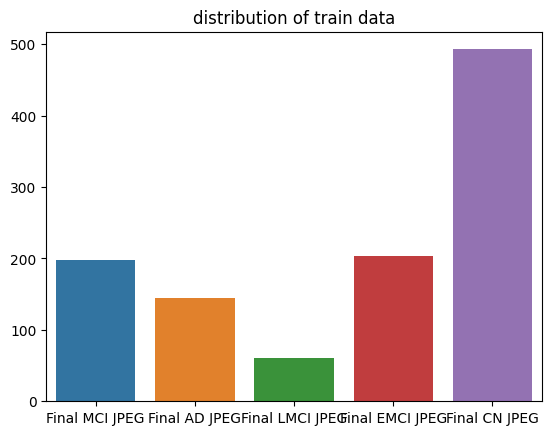

1101


In [4]:
categories = []
class_count = []
train_exm = 0
for f in os.listdir(TRAIN_DIR):
    files = gb.glob(pathname=str(TRAIN_DIR  + '//' + f + '/*.jpg'))
    categories.append(f)
    class_count.append(len(files))
    train_exm += len(files)

sns.barplot(x=categories, y=class_count).set_title("distribution of train data")

plt.show()
print(train_exm)


In [5]:
train_gen = ImageDataGenerator(
    rotation_range = 30,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    validation_split = 0.2,
    preprocessing_function = tf.keras.applications.vgg16.preprocess_input
)

test_gen = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.vgg16.preprocess_input
)


In [6]:
train_batch = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'sparse',
    subset = 'training',
    seed = SEED
)
valid_batch = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'sparse',
    subset = 'validation',
    seed = SEED
)
test_batch = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'sparse',
    seed = SEED
)

Found 883 images belonging to 5 classes.
Found 218 images belonging to 5 classes.
Found 195 images belonging to 5 classes.


In [27]:
img_shape = (IMG_SIZE, IMG_SIZE) + (3,)
base_model = tf.keras.applications.VGG16(input_shape=img_shape, include_top=False,  weights='imagenet')
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [28]:
inputs = tf.keras.Input(shape=(IMG_SIZE,IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
output = tf.keras.layers.Dense(5, activation='softmax')(x)

model = tf.keras.Model(inputs, output)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d_3   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_12 (Dense)            (None, 512)               262656    
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 256)               131328    
                                                           

In [29]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    loss= tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

In [30]:
h = model.fit(
    train_batch,
    steps_per_epoch = 642 // BATCH_SIZE,
    validation_data=valid_batch,
    validation_steps=158 // BATCH_SIZE,
    epochs=10,
)

Epoch 1/10
20/20 [==============================] - 12s 336ms/step - loss: 2.5689 - accuracy: 0.3429 - val_loss: 1.5680 - val_accuracy: 0.4375
Epoch 2/10
20/20 [==============================] - 5s 261ms/step - loss: 1.9492 - accuracy: 0.4328 - val_loss: 1.4739 - val_accuracy: 0.4141
Epoch 3/10
20/20 [==============================] - 7s 371ms/step - loss: 1.5056 - accuracy: 0.3987 - val_loss: 1.4502 - val_accuracy: 0.4219
Epoch 4/10
20/20 [==============================] - 6s 283ms/step - loss: 1.4495 - accuracy: 0.4561 - val_loss: 1.4238 - val_accuracy: 0.4141
Epoch 5/10
20/20 [==============================] - 5s 270ms/step - loss: 1.4783 - accuracy: 0.4322 - val_loss: 1.4295 - val_accuracy: 0.4531
Epoch 6/10
20/20 [==============================] - 7s 334ms/step - loss: 1.4333 - accuracy: 0.4577 - val_loss: 1.4478 - val_accuracy: 0.4375
Epoch 7/10
20/20 [==============================] - 5s 273ms/step - loss: 1.4427 - accuracy: 0.4290 - val_loss: 1.4225 - val_accuracy: 0.4844
Epoch

In [32]:
for layer in base_model.layers[-7:]:
  layer.trainable = True


In [33]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    loss= tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

In [34]:
h1 = model.fit(
    train_batch,
    steps_per_epoch = 642 // BATCH_SIZE,
    validation_data=valid_batch,
    validation_steps=158 // BATCH_SIZE,
    epochs=10,
)

Epoch 1/10
20/20 [==============================] - 13s 294ms/step - loss: 1.4269 - accuracy: 0.4530 - val_loss: 1.4105 - val_accuracy: 0.4688
Epoch 2/10
20/20 [==============================] - 7s 332ms/step - loss: 1.4409 - accuracy: 0.4328 - val_loss: 1.4566 - val_accuracy: 0.4219
Epoch 3/10
20/20 [==============================] - 6s 274ms/step - loss: 1.4284 - accuracy: 0.4469 - val_loss: 1.4123 - val_accuracy: 0.4531
Epoch 4/10
20/20 [==============================] - 7s 327ms/step - loss: 1.4646 - accuracy: 0.4450 - val_loss: 1.4239 - val_accuracy: 0.4531
Epoch 5/10
20/20 [==============================] - 5s 264ms/step - loss: 1.4227 - accuracy: 0.4391 - val_loss: 1.4114 - val_accuracy: 0.4375
Epoch 6/10
20/20 [==============================] - 6s 287ms/step - loss: 1.4432 - accuracy: 0.4338 - val_loss: 1.5715 - val_accuracy: 0.4141
Epoch 7/10
20/20 [==============================] - 6s 298ms/step - loss: 1.4549 - accuracy: 0.4437 - val_loss: 1.3864 - val_accuracy: 0.5000
Epoch

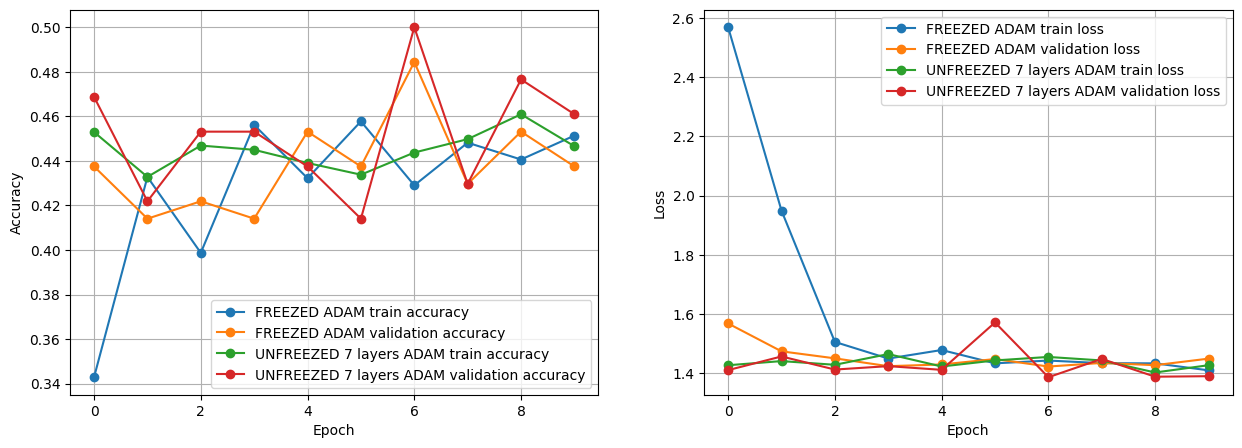

In [35]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(h.history['accuracy'], 'o-', label='FREEZED ADAM train accuracy')
plt.plot(h.history['val_accuracy'], 'o-', label = 'FREEZED ADAM validation accuracy')

plt.plot(h1.history['accuracy'], 'o-', label='UNFREEZED 7 layers ADAM train accuracy')
plt.plot(h1.history['val_accuracy'], 'o-', label = 'UNFREEZED 7 layers ADAM validation accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(h.history['loss'], 'o-', label='FREEZED ADAM train loss')
plt.plot(h.history['val_loss'], 'o-', label='FREEZED ADAM validation loss')

plt.plot(h1.history['loss'], 'o-', label='UNFREEZED 7 layers ADAM train loss')
plt.plot(h1.history['val_loss'], 'o-', label='UNFREEZED 7 layers ADAM validation loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.show()